# Dataset с Kaggle

###Reading and visualization

In [ ]:
!pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-0mpz4r6_
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-0mpz4r6_
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263953 sha256=5f04ebd7e7c626c52579b967850b18e51849cfdccc6e99ce8bdf48d5d56f5259
  Stored in directory: /tmp/pip-ephem-wheel-cache-l07cme3r/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [ ]:
%matplotlib inline
from google.colab import drive
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import zipfile
pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = zipfile.ZipFile('/content/drive/MyDrive/EPAM/KAGGLE.zip', "r")

In [ ]:
annFile= data.extract('train/COCO_train_annos.json')
mul_annFile= data.extract('train/COCO_mul_train_annos.json')

In [ ]:
# initialize coco api for instance annotations
coco=COCO(annFile)
mul_coco=COCO(mul_annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# display categories and supercategories

#Single Class #Damage dataset
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories for damages: \n{}\n'.format(', '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories for damages: \n{}\n'.format(', '.join(nms)))

#Multi Class #Parts dataset

mul_cats = mul_coco.loadCats(mul_coco.getCatIds())
mul_nms=[cat['name'] for cat in mul_cats]
print('COCO categories for parts: \n{}\n'.format(', '.join(mul_nms)))

mul_nms = set([mul_cat['supercategory'] for mul_cat in mul_cats])
print('COCO supercategories for parts: \n{}\n'.format(', '.join(mul_nms)))

COCO categories for damages: 
damage

COCO supercategories for damages: 
part

COCO categories for parts: 
headlamp, rear_bumper, door, hood, front_bumper

COCO supercategories for parts: 
part



In [ ]:
# get all images containing 'damage' category, select one at random
catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );

In [ ]:
#imgIds

In [ ]:
random_img_id = random.choice(imgIds)
#print("{} image id was selected at random from the {} list".format(random_img_id, imgIds))

In [ ]:
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)

Image details 
 {'coco_url': '', 'date_captured': '2020-07-14 09:59:34.190485', 'file_name': '54.jpg', 'flickr_url': '', 'height': 1024, 'id': 38, 'license': 1, 'width': 1024}


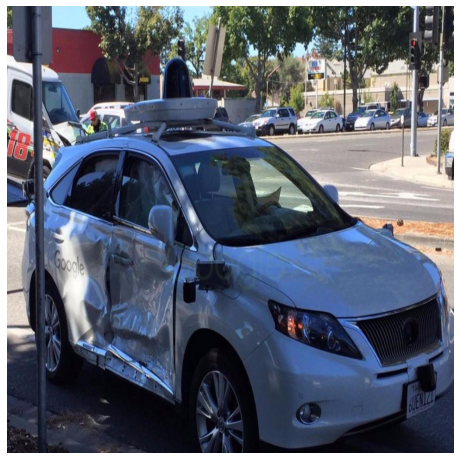

In [ ]:
I = io.imread(data.extract('train' + '/' + img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
#get damage annotations
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)

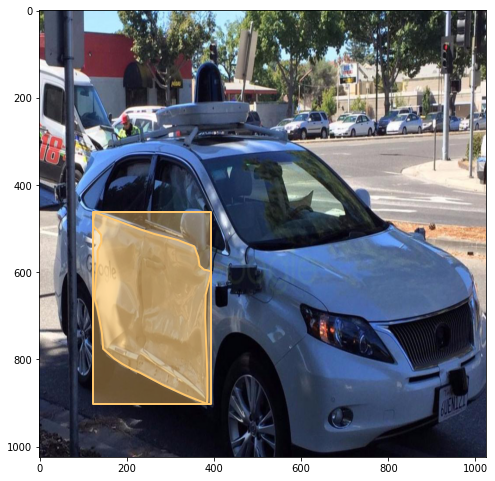

In [ ]:
#Plot damages
plt.imshow(I)
plt.axis('on')
coco.showAnns(anns, draw_bbox=True)

In [ ]:
#get parts annotations
mul_annIds = mul_coco.getAnnIds(imgIds=imgId,iscrowd=None)
mul_anns = mul_coco.loadAnns(mul_annIds)

In [ ]:
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(mul_coco.cats.values()):
    category_map.update({ele['id']:ele['name']})

In [ ]:
category_map

{1: 'headlamp', 2: 'rear_bumper', 3: 'door', 4: 'hood', 5: 'front_bumper'}

Parts are: ['door', 'hood', 'front_bumper', 'headlamp']


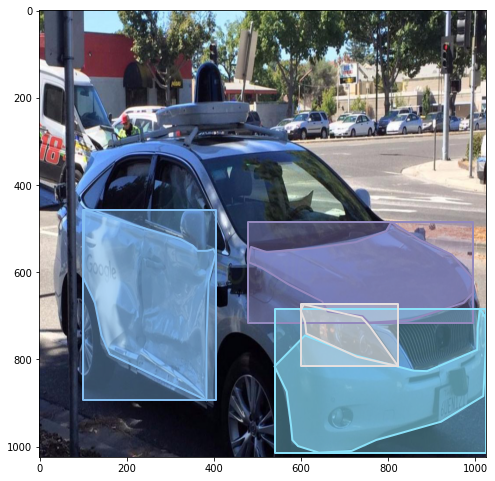

In [ ]:
#Create a list of parts in the image
parts = []
for region in mul_anns:
    parts.append(category_map[region['category_id']])

print("Parts are:", parts) 

#Plot Parts
I = io.imread('train' + '/' + img['file_name'])
plt.imshow(I)
plt.axis('on')
mul_coco.showAnns(mul_anns, draw_bbox=True )

##Models

###Faster R-CNN

In [ ]:
import torchvision 
import torch
from torchvision import transforms

In [ ]:
convert_tensor = transforms.ToTensor()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #pretrained model 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
#ПРИМЕР
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
#print(images)
targets = []
for i in range(len(images)):
  d = {}
  d['boxes'] = torchvision.ops.box_convert(boxes[i],'xywh','xyxy')
  d['labels'] = labels[i]
  targets.append(d)
print(d)
output = model(images, targets)
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

{'boxes': tensor([[0.7013, 0.4367, 1.2647, 1.4122],
        [0.6881, 0.6600, 1.1233, 0.8890],
        [0.2332, 0.9558, 0.3917, 1.3922],
        [0.5855, 0.1340, 1.3687, 1.1010],
        [0.8736, 0.7205, 1.6331, 0.7452],
        [0.8239, 0.2078, 1.5379, 0.2587],
        [0.3669, 0.1438, 0.8817, 0.2446],
        [0.8250, 0.6457, 1.1211, 0.9551],
        [0.5811, 0.2246, 1.3536, 0.3604],
        [0.4516, 0.3430, 1.1936, 1.2641],
        [0.9711, 0.8080, 1.0629, 1.4675]]), 'labels': tensor([10, 30, 28, 53, 65, 44, 80,  8,  4, 31, 55])}


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

In [ ]:
#Все картинки из папки train преобразовать в список tensor 

catIds = coco.getCatIds(catNms=['damage']);
imgIds = coco.getImgIds(catIds=catIds );
images = []
for id in imgIds:
  imgId = coco.getImgIds(id)
  img = coco.loadImgs(imgId)[0]
  I = io.imread(data.extract('train' + '/' + img['file_name']))
  images.append(convert_tensor(I))
  

In [ ]:
import numpy as np
#Собрать все boxes и labels
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)
boxes = []
labels = []
target = []
for id in imgIds:
  annIds = coco.getAnnIds(id,iscrowd=None)
  anots = coco.loadAnns(annIds)
  box = []
  lab = []
  d = {}
  for n in range(len(anots)):
    box.append(anots[n]['bbox'])
    lab.append(anots[n]['category_id'])
  d['boxes'] = torchvision.ops.box_convert(torch.Tensor(box),'xywh','xyxy')
  d['labels'] = torch.Tensor(lab)
  target.append(d)

In [ ]:
#model(images, target) #падает из-за нехватки ОЗУ

#### SDD

In [ ]:
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
model.eval()
model(images,target) #Все хорошо работает

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

[{'boxes': tensor([[2.4896e+00, 1.2561e+01, 1.0240e+03, 9.6492e+02],
          [4.1426e+00, 2.3059e+01, 1.0240e+03, 9.5905e+02],
          [4.1255e+00, 1.1528e+01, 1.0240e+03, 9.5748e+02],
          [8.3670e+02, 5.6042e+02, 9.5001e+02, 7.9275e+02],
          [2.9834e+02, 4.4151e+02, 4.0723e+02, 6.6980e+02],
          [7.7854e+02, 5.2368e+02, 9.9108e+02, 8.2473e+02],
          [2.3849e+02, 3.7352e+02, 4.8519e+02, 6.3846e+02],
          [1.3057e+01, 7.6918e+01, 6.2527e+01, 1.5583e+02],
          [1.7153e+02, 1.6564e+02, 3.9289e+02, 6.6157e+02],
          [2.4376e+02, 4.2506e+02, 3.5358e+02, 6.6840e+02],
          [5.7925e+01, 8.4447e+01, 1.3166e+02, 1.5193e+02],
          [3.5279e+02, 4.4988e+02, 4.6285e+02, 6.6722e+02],
          [3.0413e+02, 2.2205e+01, 4.0616e+02, 2.1906e+02],
          [4.5614e+01, 8.0306e+01, 9.3376e+01, 1.5240e+02],
          [3.5850e+02, 1.7910e+01, 4.5780e+02, 2.1497e+02],
          [6.5115e+02, 3.9364e+02, 1.0240e+03, 6.0117e+02],
          [9.1194e+01, 8.2198e+

####Mask R-CNN


In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
#model(images,target) # падает из-за ОЗУ

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

####YOLO

In [ ]:
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 

     |████████████████████████████████| 596 kB 5.4 MB/s 


In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-2-9 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)



  0%|          | 0.00/14.0M [00:00<?, ?B/s]

In [ ]:
#model(images, target) 

#Dataset собственного производства:)

In [ ]:
# Set dataset path
datasetPath = "/content/drive/MyDrive/EPAM/dataset.zip"
coco_file_Path = "/content/drive/MyDrive/EPAM/custom_data.json" # set empty "" to import annotation from archive

## Import libs, dataset, coco annotation

In [ ]:
%matplotlib inline
from google.colab import drive
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import zipfile
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# For visualization
import os
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image

# Torch
import torchvision 
import torch
from torchvision import transforms

In [ ]:
drive.mount('/content/drive')

# Import dataset
cardamage = zipfile.ZipFile(datasetPath, "r")

# Import coco annotatation
if len(coco_file_Path):
    F_coco=COCO(coco_file_Path)
else: # Traditional import
    File_coco = cardamage.extract('data/data_coco.json')
    F_coco=COCO(File_coco)
    
catIds = F_coco.getCatIds(catNms=['damage type']);
imgIds = F_coco.getImgIds(catIds=catIds)
annIds = F_coco.getAnnIds(imgIds=imgIds,iscrowd=None)
anns = F_coco.loadAnns(annIds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


## Visualisation

In [ ]:
def output_image(_image):
    _img = io.imread(cardamage.extract(f"data/{_image['file_name']}"))
    plt.axis('off')
    plt.imshow(_img)
    plt.show()

    #get damage annotations
    annIds = F_coco.getAnnIds(imgIds=_image["id"])
    anns = F_coco.loadAnns(annIds)

    plt.imshow(_img)
    plt.axis('on')
    F_coco.showAnns(anns, draw_bbox=True)
    return

In [ ]:
# Load random image
random_img_id = random.choice(imgIds)
print(f"{random_img_id} image id was selected at random from the {imgIds} list\n")

imgId = F_coco.getImgIds(imgIds = [random_img_id])
img = F_coco.loadImgs(imgId)[0]
print("Image details \n",img)

86 image id was selected at random from the [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148] list

Image details 
 {'id': 86, 'width': 540, 'height': 360, 'file_name': 'img_(15).jpg', 'license': 0, 'flickr_url': 'img_(15).jpg', 'coco_url': 'img_(15).jpg', 'date_captured': ''}


## Data preprocessing

In [ ]:
convert_tensor = transforms.ToTensor()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
images = []
for id in imgIds:
    imgId = F_coco.getImgIds(id)
    img = F_coco.loadImgs(imgId)[0]
    I = io.imread(cardamage.extract(f"data/{img['file_name']}"))
    images.append(convert_tensor(I))

In [ ]:
len(images)

148

In [ ]:
# Collect all boxes and labels from annotation
annIds = F_coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = F_coco.loadAnns(annIds)

boxes  = []
labels = []
target = []
for id in imgIds:
    annIds = F_coco.getAnnIds(id,iscrowd=None)
    anots = F_coco.loadAnns(annIds)
    box = []
    lab = []
    d = {}
    for n in range(len(anots)):
        box.append(anots[n]['bbox'])
        lab.append(anots[n]['category_id'])
    #print( id)
    d['boxes'] = torchvision.ops.box_convert(torch.Tensor(box), 'xywh', 'xyxy')
    d['labels'] = torch.Tensor(lab)
    target.append(d)

##Модели

In [ ]:
#model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
#model.eval()
#model(images,target) #Падает из-за ОЗУ - 148 картинок

##Метрики

IoU или индекс Жаккара

https://pytorch.org/ignite/master/generated/ignite.metrics.IoU.html

Dice score

https://discuss.pytorch.org/t/implementation-of-dice-loss/53552

# Resize

In [ ]:
!pip install --upgrade albumentations         > /dev/null
print("paste y")
!pip uninstall opencv-python-headless         > /dev/null
!pip install opencv-python-headless==4.1.2.30 > /dev/null

import cv2 as cv
import albumentations as a
from albumentations import augmentations

paste y
y


In [ ]:
class Image(object):
    """docstring"""
 
    def __init__(self, img, bboxes, anns):
        """Constructor"""

        self.img = img
        self.bboxes = bboxes
        self.category_id = [anns[0].get("category_id")]

        self.category_id_to_name = { 1: "dent", 2: "broken_glass", 3: "deflated_wheel", 4: "scratch", 5: "broken_headlight"}
        names = []
        for index in self.getCategoryId():
            names.append(self.category_id_to_name.get(anns[0].get("category_id")))

        self.category_name = names
    
    def getBboxes(self):
        return self.bboxes
    
    def getImg(self):
        return self.img

    def getCategoryId(self):
        return self.category_id

    def getCategoryName(self):
        return self.category_name

    def get_id_to_name_dict(self):
        return self.category_id_to_name


In [ ]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    ((text_width, text_height), _) = cv.getTextSize(class_name, cv.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(img)

In [ ]:
def get_training_augmentation(_src, _bboxes, _category_id):
    train_transform = [
        #a.HorizontalFlip(p=0.5),
        #a.VerticalFlip(p=0.5),
        #a.ShiftScaleRotate(scale_limit=0.20, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=cv.BORDER_CONSTANT, value=0),
        #a.GridDistortion(p=0.5),
        a.Resize(200, 200),
        #a.RandomCrop(*crop_size),
        #a.ChannelShuffle(),
        #a.InvertImg(),
        #a.ToGray(),
        #a.Normalize(),
    ]
    transform = a.Compose(train_transform, bbox_params=a.BboxParams(format='coco', label_fields=['category_id']))
    return transform(image=_src, bboxes=_bboxes, category_id=_category_id)['image'], transform(image=_src, bboxes=_bboxes, category_id=_category_id)['bboxes']

In [ ]:
random_img_id = random.choice(imgIds)
img_descriptor = F_coco.loadImgs(random_img_id)
file_name =  f"data/{img_descriptor[0]['file_name']}"

# read image
src = cv.imread(file_name, cv.COLOR_BGR2RGB)

# read anns
annIds = F_coco.getAnnIds(imgIds=random_img_id)
anns = F_coco.loadAnns(annIds)
anns = anns

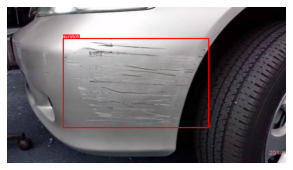

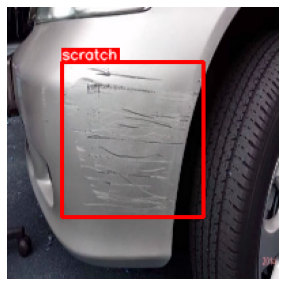

In [ ]:
transformed_image, transformed_bboxes = get_training_augmentation(src,                          \
                                                                  [anns[0].get("bbox")],        \
                                                                  [anns[0].get("category_id")]  \
)

category_id_to_name = { 1: "dent", 2: "broken_glass", 3: "deflated_wheel", 4: "scratch", 5: "broken_headlight"}

visualize(src, [anns[0].get("bbox")], [anns[0].get("category_id")], category_id_to_name)            # source
visualize(transformed_image, transformed_bboxes, [anns[0].get("category_id")], category_id_to_name) # resize

#ХЗ

###Переопределение класса torch.utils.data.Dataset

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import zipfile


class CarDamageDataSet(torch.utils.data.Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms
        File_coco = data.extract('data/data_coco.json')
        self.F_coco=COCO(File_coco)
        catIds = self.F_coco.getCatIds(catNms=['damage type']);
        self.imgIds = self.F_coco.getImgIds(catIds=catIds);
        self.img = self.F_coco.loadImgs(self.imgIds)
        

    def __getitem__(self,idx):
       boxes = []
       labels = []
       target = []
       annIds = self.F_coco.getAnnIds(idx,iscrowd=None)
       anots = self.F_coco.loadAnns(annIds)
       box = []
       lab = []
       d = {}
       for n in range(len(anots)):
         box.append(anots[n]['bbox'])
         lab.append(anots[n]['category_id'])
       d['boxes'] = torchvision.ops.box_convert(torch.Tensor(box),'xywh','xyxy')
       d['labels'] = torch.Tensor(lab)
       target.append(d)

       return target

    def __len__(self):
        return len(self.img)


In [ ]:
dataset = CarDamageDataSet(zipfile.ZipFile(datasetPath, "r"))

FileNotFoundError: ignored

In [ ]:
dataset

###Функция для модели

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

      
def get_instance_detection_model(num_classes):
    # load an instance detection  model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  
    return model

In [ ]:
!pip install utils > /dev/null

In [ ]:
!git clone https://github.com/pytorch/vision.git   > /dev/null
!cd vision                                         > /dev/null
!cp vision/references/detection/utils.py ./        > /dev/null
!cp vision/references/detection/transforms.py ./   > /dev/null
!cp vision/references/detection/coco_eval.py ./    > /dev/null
!cp vision/references/detection/engine.py ./       > /dev/null
!cp vision/references/detection/coco_utils.py ./   > /dev/null

fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
import utils
from utils import MetricLogger
from torch.utils.data import DataLoader
from engine import train_one_epoch, evaluate

In [ ]:
import utils
from torch.utils.data import DataLoader
from engine import train_one_epoch, evaluate 

# use our dataset and defined transformations
dataset = CarDamageDataSet(zipfile.ZipFile(datasetPath, "r"))
dataset_test = CarDamageDataSet(zipfile.ZipFile(datasetPath, "r"))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4)
    #collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4)
    #collate_fn=utils.collate_fn)

"""Now let's instantiate the model and the optimizer"""

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 5

# get the model using our helper function
model = get_instance_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

"""And now let's train the model for 10 epochs, evaluating at the end of every epoch."""

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

NameError: ignored

In [ ]:
#wtf mzfk
convert_tensor = transforms.ToTensor()

images = []
for id in imgIds:
    imgId = F_coco.getImgIds(id)
    img = F_coco.loadImgs(imgId)[0]
    I = io.imread(cardamage.extract(f"data/{img['file_name']}"))
    images.append(convert_tensor(I))

annIds = F_coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = F_coco.loadAnns(annIds)

boxes  = []
labels = []
target = []
for id in imgIds:
    annIds = F_coco.getAnnIds(id,iscrowd=None)
    anots = F_coco.loadAnns(annIds)
    box = []
    lab = []
    d = {}
    for n in range(len(anots)):
        box.append(anots[n]['bbox'])
        lab.append(anots[n]['category_id'])
    #print( id)
    d['boxes'] = torchvision.ops.box_convert(torch.Tensor(box), 'xywh', 'xyxy')
    d['labels'] = torch.Tensor(lab)
    target.append(d)

In [ ]:
model = get_instance_detection_model(5)
#model(transformed_image, transformed_bboxes)

TypeError: ignored

# VideoCapture example (not for collab)

In [ ]:
def show_webcam(mirror=False):
    cam = cv.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        if mirror: 
            img = cv.flip(img, 1)
        cv.imshow('my webcam', img)
        if cv.waitKey(1) == 27: 
            break  # esc to quit
    cv.destroyAllWindows()

#show_webcam(mirror=True)